In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, accuracy_score
from graspologic.embed import ClassicalMDS
from graspologic.utils import remap_labels

import sys
sys.path.append('/Users/dianelee/Documents/Github/ndd-dlee')

from utils.utils import calculate_dissim

# Clustering Dissimilarity Matrices
Here we will use some well-known clustering algorithms (Agglomerative clustering, GMM, K-means) from sklearn to cluster networks on the dissimilarity matrices that we generated in the discriminability notebook.

## Load Data

In [2]:
from graspologic.datasets import load_mice
from grakel import Graph

# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)
print(graphs.shape)

# initialize labels
labels = {}
for i in np.arange(0, 332):
    labels[i] = i

# Convert adjacency matrices to grakel objects
Gs = []
for graph in graphs:
    Gs.append(Graph(initialization_object = graph, node_labels=labels))
print(len(Gs))

(32, 332, 332)
32


In [3]:
def cluster_dissim(dissim_matrix: np.ndarray, labels: list, method="agg"):
    if method == "agg":
        # Agglomerative clustering
        agg = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage='average', \
            compute_distances=True).fit(dissim_matrix, y=labels)
        pred = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage='average', \
            compute_distances=True).fit_predict(dissim_matrix, y=labels)

        # construct linkage matrix
        counts = np.zeros(agg.children_.shape[0])
        n_samples = len(agg.labels_)

        for i, merge in enumerate(agg.children_):
            temp_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    temp_count += 1 
                else:
                    temp_count += counts[child_idx - n_samples]
            counts[i] = temp_count

        linkage_matrix = np.column_stack([agg.children_, agg.distances_, counts]).astype(float)

        return linkage_matrix, pred
    
    elif method in ["gmm", "kmeans"]:
        # Classical MDS
        cmds = ClassicalMDS(n_components=2, dissimilarity="precomputed")
        cmds_embedding = cmds.fit_transform(dissim_matrix)

        # cluster using GMM or K-means
        if method == "gmm":
            clustering = GaussianMixture(n_components=4, n_init=25).fit_predict(cmds_embedding, y=labels)
        elif method == "kmeans":
            clustering = KMeans(n_clusters=4, n_init=25).fit_predict(cmds_embedding, y=labels)
        else:
            print("Not a valid kernel name.")

        return cmds_embedding, clustering
    
    else:
        print("Not a valid kernel name.")

In [4]:
def compare_preds(y_true, y_pred):
    """ Compare true and predicted labels and return list of 'Correct' or 'Incorrect'. """
    preds = []
    for i, pred in enumerate(y_pred):
        if pred == y_true[i]:
            preds.append("Correct")
        else:
            preds.append("Incorrect")
    
    return preds

In [5]:
def construct_df(embedding, y_true, y_pred):
    """ Construct dataframe for plotting and remapped labels. Only for 'gmm' or 'kmeans'. """
    # x,y coordinates
    plot_df = pd.DataFrame(embedding, columns=["Dimension 1", "Dimension 2"])

    # predicted labels
    mapper_inv = {0: 'B6', 1: 'BTBR', 2: 'CAST', 3: 'DBA2'}
    y_pred = remap_labels(y_true=y_true, y_pred=y_pred)
    pred_str = np.array([mapper_inv[l] for l in list(y_pred)])
    plot_df["Genotype"] = pred_str

    # determine if predictions are accurate for each sample
    preds = compare_preds(y_true, y_pred)
    plot_df["Predictions"] = preds

    return plot_df, y_pred

In [6]:
def plot_clustering(
    algorithm: str = "agg",
    dissim_matrix: np.ndarray = None,
    linkage_matrix: np.ndarray = None,
    data: pd.DataFrame = None,
    **kwargs,
):
    sns.set_context("talk", font_scale=0.85)
    palette = {"DBA2": "#e7298a", "B6": "#1b9e77", "BTBR": "#d95f02", "CAST": "#7570b3"}

    if algorithm == "agg" and dissim_matrix is not None and linkage_matrix is not None:
        df = pd.DataFrame(mice.labels, columns = ['Labels'])
        mice_labels = df.pop("Labels")
        colors = mice_labels.map(palette).to_numpy()

        clustergrid = sns.clustermap(dissim_matrix, row_linkage=linkage_matrix, col_linkage=linkage_matrix, row_colors=colors, \
            col_colors=colors, cmap="RdBu_r", center=0, xticklabels=False, yticklabels=False, **kwargs)

        clustergrid.figure.set_facecolor('w')
        clustergrid.ax_cbar.set_title("Dissimilarity") # add color bar
        col_ax = clustergrid.ax_col_colors # add row and column colors
        col_ax.set_yticks([0.5])
        _ = col_ax.set_yticklabels(["Genotype"], va="center")
        patches = [matplotlib.patches.Patch(color=v, label=k) for k,v in palette.items()] # add legend
        clustergrid.figure.legend(handles=patches, bbox_to_anchor = (1.13, 1), title='Genotype')

        return clustergrid
        
    elif algorithm in ["gmm", "kmeans"] and data is not None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='w')
        markers = {"Incorrect": "X", "Correct": "o"}
        sns.scatterplot(x="Dimension 1", y="Dimension 2", hue=mice.labels, style="Predictions", data=data, \
            palette=palette, markers=markers, ax=ax, **kwargs)
        plt.legend(bbox_to_anchor = (1.05, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlabel('CMDS Dimension 1')
        ax.set_ylabel('CMDS Dimension 2')
        ax.tick_params(left=False, bottom=False)

        return ax
    
    else:
        print("If algorithm is 'agg', dissim_matrix and linkage_matrix must be given. If algorithm is 'gmm' or 'kmeans', \
            data must be given.")
    

## Agglomerative Clustering

Agglomerative clustering was used directly on the dissimilarity matrices, and the resulting linkage matrix and clusters were visualized with a heatmap below.

For each kernel, the accuracy score, the number of correct predictions divided by the total number of samples, and the adjusted rand index,  a similarity measure between two clusterings after being adjusted for chance, were reported. 

In [7]:
# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])

### Density

Accuracy: 0.53125
ARI: 0.20111167256189996


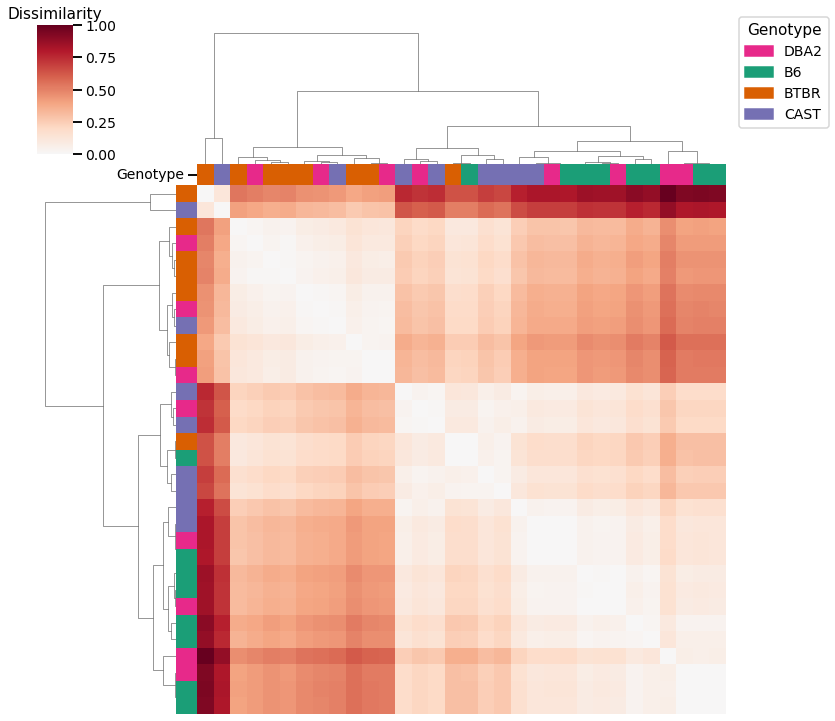

In [8]:
# calculate dissimilarity matrix
scaled_density_dissim = calculate_dissim(graphs, method="density", norm=None, normalize=True)

# cluster dissimilarity matrix
density_linkage_matrix, density_pred = cluster_dissim(scaled_density_dissim, y, method="agg")

# calculate accuracy and ARI
density_pred = remap_labels(y, density_pred)
density_agg_score = accuracy_score(y, density_pred)
density_agg_ari = adjusted_rand_score(y, density_pred)

print(f"Accuracy: {density_agg_score}")
print(f"ARI: {density_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering('agg', scaled_density_dissim, density_linkage_matrix)

### Average Edge Weight

Accuracy: 0.65625
ARI: 0.4124638612271121


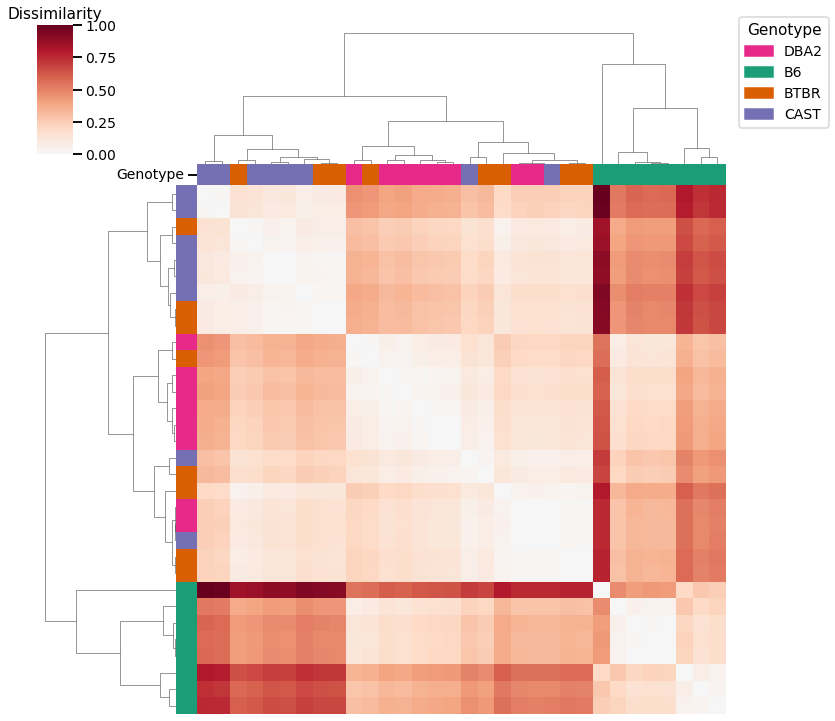

In [9]:
# calculate dissimilarity matrix
scaled_avgedgeweight_dissim = calculate_dissim(graphs, method="avgedgeweight", norm=None, normalize=True)

# cluster dissimilarity matrix
avgedgeweight_linkage_matrix, avgedgeweight_pred = cluster_dissim(scaled_avgedgeweight_dissim, y, method="agg")

# calculate accuracy and ARI
avgedgeweight_pred = remap_labels(y, avgedgeweight_pred)
avgedgeweight_agg_score = accuracy_score(y, avgedgeweight_pred)
avgedgeweight_agg_ari = adjusted_rand_score(y, avgedgeweight_pred)

print(f"Accuracy: {avgedgeweight_agg_score}")
print(f"ARI: {avgedgeweight_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering('agg', scaled_avgedgeweight_dissim, avgedgeweight_linkage_matrix)

### Average of Adjacency Matrix

Accuracy: 0.65625
ARI: 0.3134054954204829


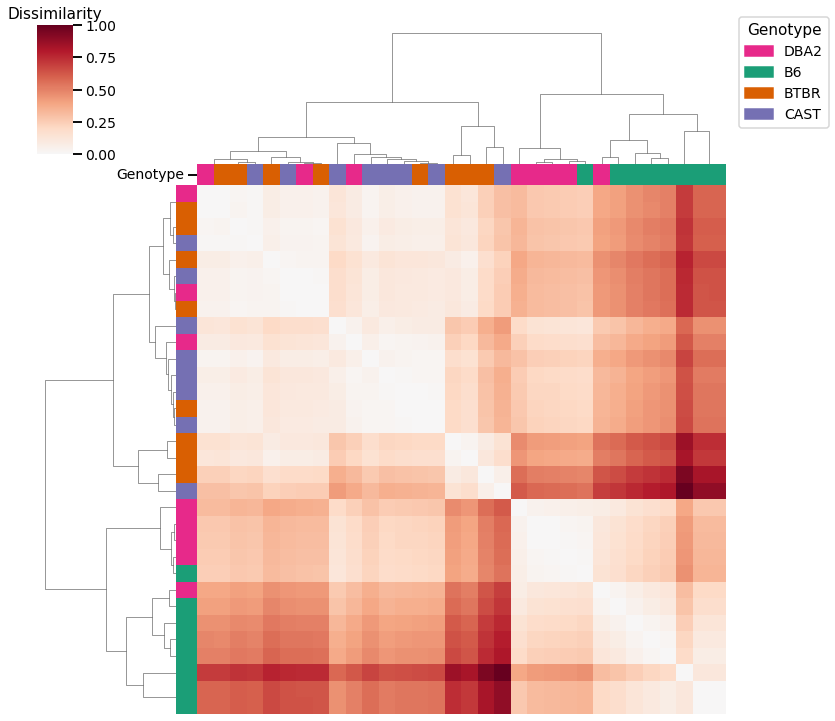

In [10]:
# calculate dissimilarity matrix
scaled_avgadjmat_dissim = calculate_dissim(graphs, method="avgadjmatrix", norm=None, normalize=True)

# cluster dissimilarity matrix
avgadjmat_linkage_matrix, avgadjmat_pred = cluster_dissim(scaled_avgadjmat_dissim, y, method="agg")

# calculate accuracy and ARI
avgadjmat_pred = remap_labels(y, avgadjmat_pred)
avgadjmat_agg_score = accuracy_score(y, avgadjmat_pred)
avgadjmat_agg_ari = adjusted_rand_score(y, avgadjmat_pred)

print(f"Accuracy: {avgadjmat_agg_score}")
print(f"ARI: {avgadjmat_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering('agg', scaled_avgadjmat_dissim, avgadjmat_linkage_matrix)

### Node Degrees - L1 Norm

Accuracy: 0.46875
ARI: 0.17706740792216819


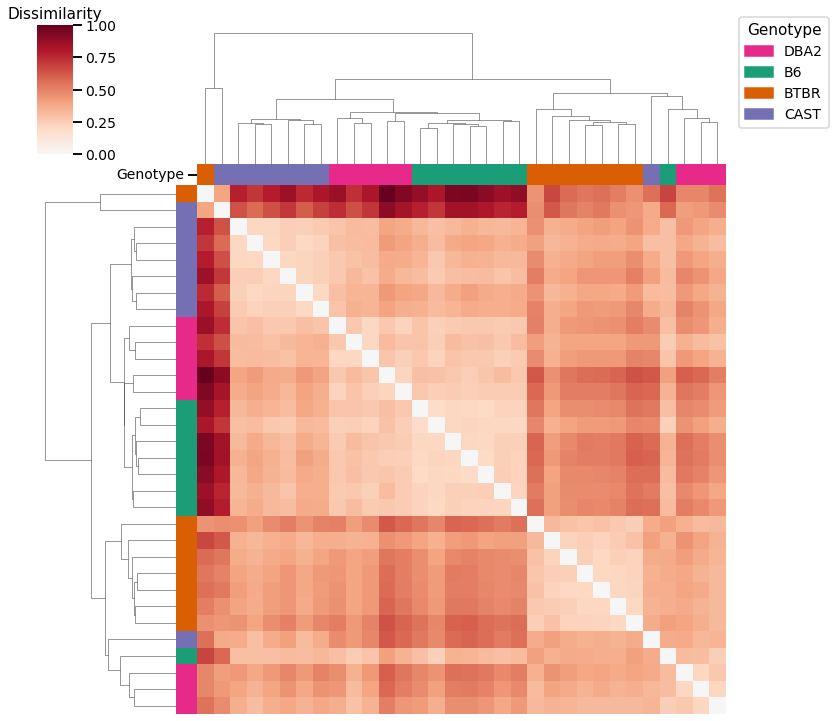

In [11]:
# calculate dissimilarity matrix
scaled_nodedeg_dissim_l1 = calculate_dissim(graphs, method="degree", norm="l1", normalize=True)

# cluster dissimilarity matrix
nodedeg_l1_linkage_matrix, nodedeg_l1_pred = cluster_dissim(scaled_nodedeg_dissim_l1, y, method="agg")

# calculate accuracy and ARI
nodedeg_l1_pred = remap_labels(y, nodedeg_l1_pred)
nodedeg_l1_agg_score = accuracy_score(y, nodedeg_l1_pred)
nodedeg_l1_agg_ari = adjusted_rand_score(y, nodedeg_l1_pred)

print(f"Accuracy: {nodedeg_l1_agg_score}")
print(f"ARI: {nodedeg_l1_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering('agg', scaled_nodedeg_dissim_l1, nodedeg_l1_linkage_matrix)

### Node Degrees - L2 Norm

Accuracy: 0.5
ARI: 0.27552275522755226


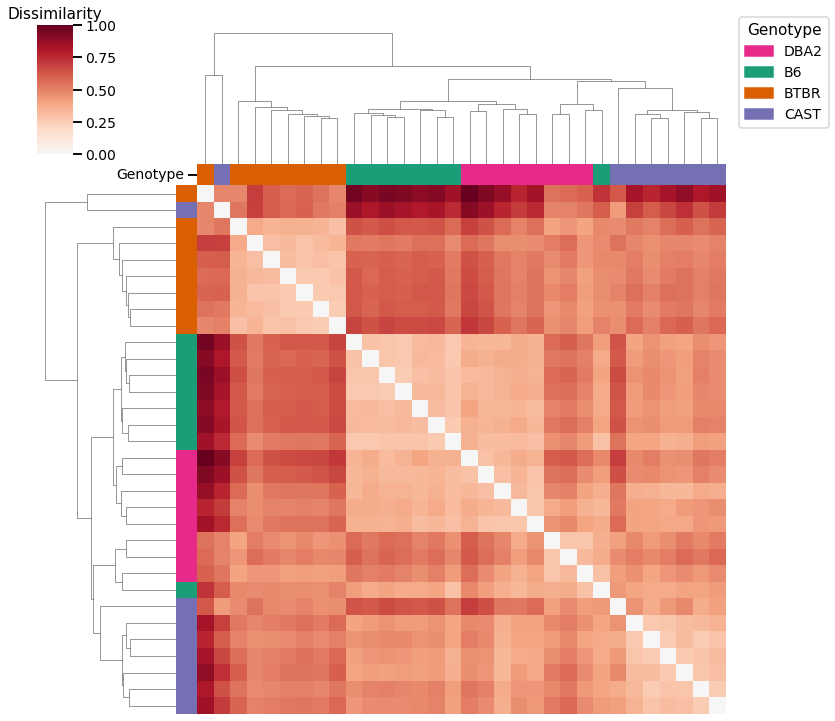

In [12]:
# calculate dissimilarity matrix
scaled_nodedeg_dissim_l2 = calculate_dissim(graphs, method="degree", norm="l2", normalize=True)

# cluster dissimilarity matrix
nodedeg_l2_linkage_matrix, nodedeg_l2_pred = cluster_dissim(scaled_nodedeg_dissim_l2, y, method="agg")

# calculate accuracy and ARI
nodedeg_l2_pred = remap_labels(y, nodedeg_l2_pred)
nodedeg_l2_agg_score = accuracy_score(y, nodedeg_l2_pred)
nodedeg_l2_agg_ari = adjusted_rand_score(y, nodedeg_l2_pred)

print(f"Accuracy: {nodedeg_l2_agg_score}")
print(f"ARI: {nodedeg_l2_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering('agg', scaled_nodedeg_dissim_l2, nodedeg_l2_linkage_matrix)

### Node Strength - L1 Norm

Accuracy: 0.875
ARI: 0.7122838944494996


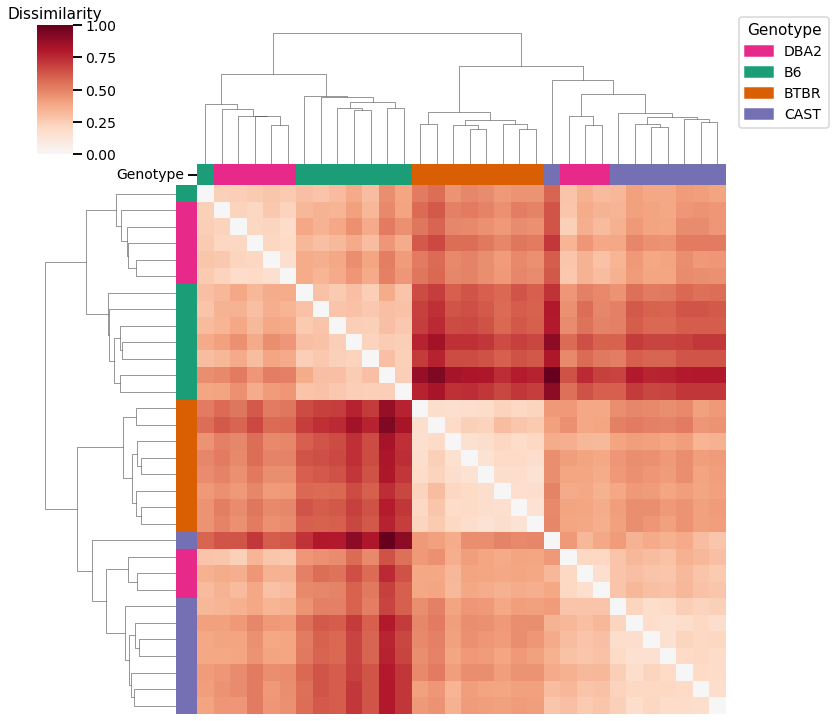

In [13]:
# calculate dissimilarity matrix
scaled_nodestr_dissim_l1 = calculate_dissim(graphs, method="strength", norm="l1", normalize=True)

# cluster dissimilarity matrix
nodestr_l1_linkage_matrix, nodestr_l1_pred = cluster_dissim(scaled_nodestr_dissim_l1, y, method="agg")

# calculate accuracy and ARI
nodestr_l1_pred = remap_labels(y, nodestr_l1_pred)
nodestr_l1_agg_score = accuracy_score(y, nodestr_l1_pred)
nodestr_l1_agg_ari = adjusted_rand_score(y, nodestr_l1_pred)

print(f"Accuracy: {nodestr_l1_agg_score}")
print(f"ARI: {nodestr_l1_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering('agg', scaled_nodestr_dissim_l1, nodestr_l1_linkage_matrix)

### Node Strength - L2 Norm

Accuracy: 0.75
ARI: 0.5847123719464145


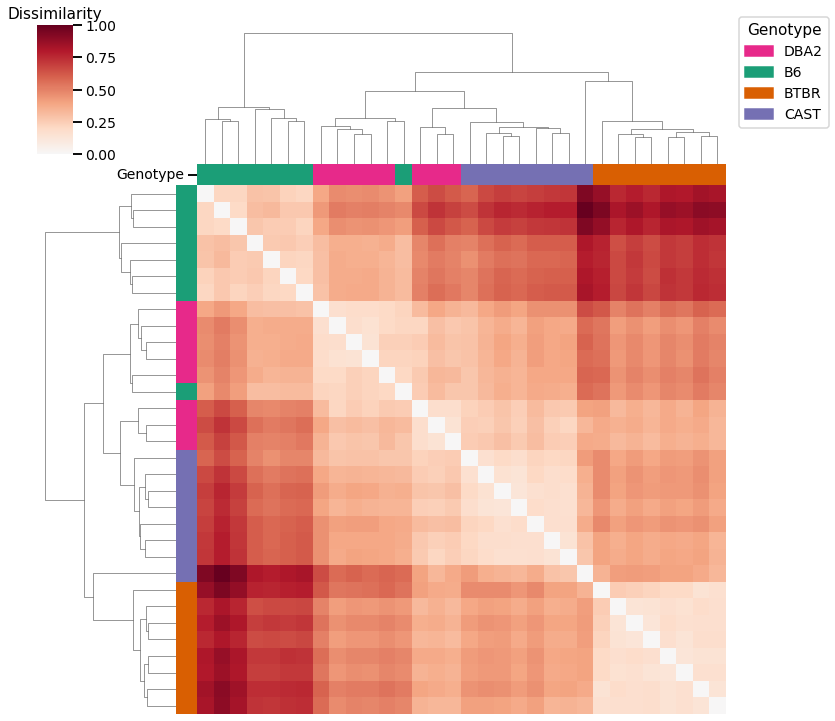

In [14]:
# calculate dissimilarity matrix
scaled_nodestr_dissim_l2 = calculate_dissim(graphs, method="strength", norm="l2", normalize=True)

# cluster dissimilarity matrix
nodestr_l2_linkage_matrix, nodestr_l2_pred = cluster_dissim(scaled_nodestr_dissim_l2, y, method="agg")

# calculate accuracy and ARI
nodestr_l2_pred = remap_labels(y, nodestr_l2_pred)
nodestr_l2_agg_score = accuracy_score(y, nodestr_l2_pred)
nodestr_l2_agg_ari = adjusted_rand_score(y, nodestr_l2_pred)

print(f"Accuracy: {nodestr_l2_agg_score}")
print(f"ARI: {nodestr_l2_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering('agg', scaled_nodestr_dissim_l2, nodestr_l2_linkage_matrix)

### Edge weights - L1 Norm

Accuracy: 0.96875
ARI: 0.9137771184869276


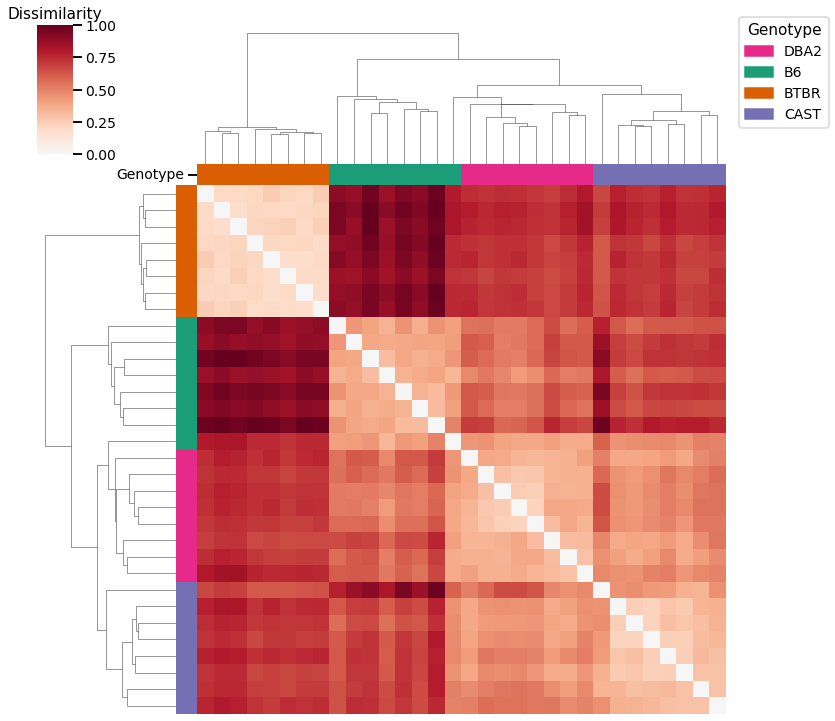

In [15]:
# calculate dissimilarity matrix
scaled_edgeweight_dissim_l1 = calculate_dissim(graphs, method="edgeweight", norm="l1", normalize=True)

# cluster dissimilarity matrix
edgeweight_l1_linkage_matrix, edgeweight_l1_pred = cluster_dissim(scaled_edgeweight_dissim_l1, y, method="agg")

# calculate accuracy and ARI
edgeweight_l1_pred = remap_labels(y, edgeweight_l1_pred)
edgeweight_l1_agg_score = accuracy_score(y, edgeweight_l1_pred)
edgeweight_l1_agg_ari = adjusted_rand_score(y, edgeweight_l1_pred)

print(f"Accuracy: {edgeweight_l1_agg_score}")
print(f"ARI: {edgeweight_l1_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering('agg', scaled_edgeweight_dissim_l1, edgeweight_l1_linkage_matrix)

### Edge weights - L2 Norm

Accuracy: 0.96875
ARI: 0.9137771184869276


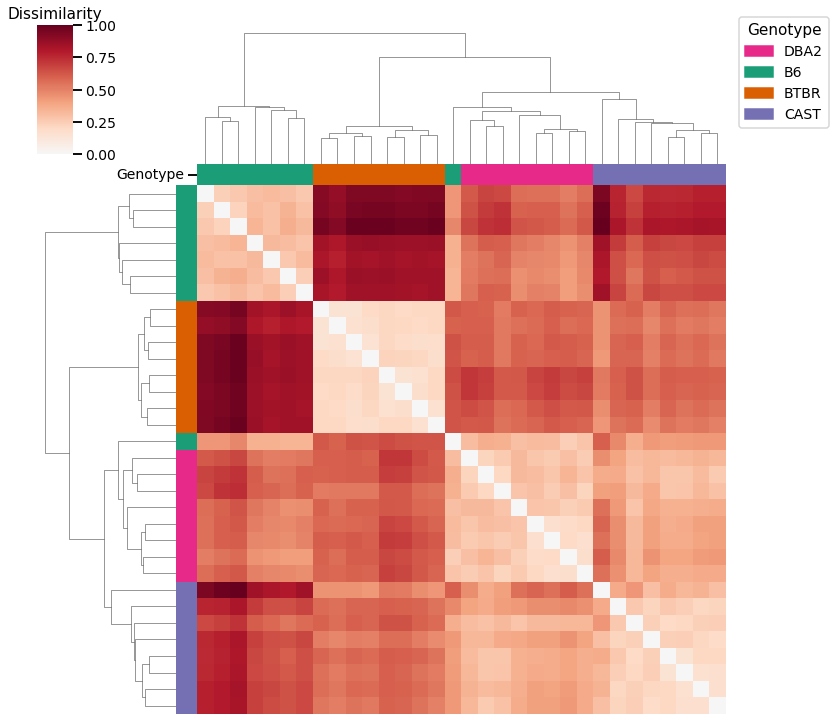

In [16]:
# calculate dissimilarity matrix
scaled_edgeweight_dissim_l2 = calculate_dissim(graphs, method="edgeweight", norm="l2", normalize=True)

# cluster dissimilarity matrix
edgeweight_l2_linkage_matrix, edgeweight_l2_pred = cluster_dissim(scaled_edgeweight_dissim_l2, y, method="agg")

# calculate accuracy and ARI
edgeweight_l2_pred = remap_labels(y, edgeweight_l2_pred)
edgeweight_l2_agg_score = accuracy_score(y, edgeweight_l2_pred)
edgeweight_l2_agg_ari = adjusted_rand_score(y, edgeweight_l2_pred)

print(f"Accuracy: {edgeweight_l2_agg_score}")
print(f"ARI: {edgeweight_l2_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering('agg', scaled_edgeweight_dissim_l2, edgeweight_l2_linkage_matrix)

### Omnibus Embedding

Accuracy: 1.0
ARI: 1.0


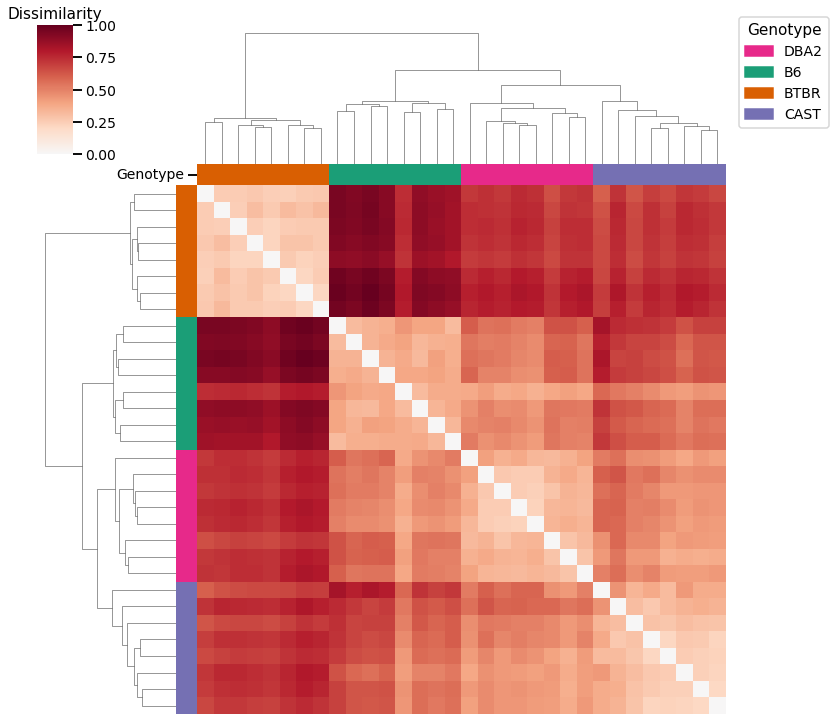

In [17]:
from graspologic.embed import OmnibusEmbed

# embed using Omni
embedder = OmnibusEmbed(n_elbows=3)
omni_embedding = embedder.fit_transform(graphs)

# calculate dissimilarity matrix
omni_matrix = np.zeros((len(graphs), len(graphs)))
for i, embedding1 in enumerate(omni_embedding):
    for j, embedding2 in enumerate(omni_embedding):
        dist = np.linalg.norm(embedding1 - embedding2, ord="fro")
        omni_matrix[i, j] = dist

scaled_omni_dissim = omni_matrix / np.max(omni_matrix)

# cluster dissimilarity matrix
omni_linkage_matrix, omni_pred = cluster_dissim(scaled_omni_dissim, y, method="agg")

# calculate accuracy and ARI
omni_pred = remap_labels(y, omni_pred)
omni_agg_score = accuracy_score(y, omni_pred)
omni_agg_ari = adjusted_rand_score(y, omni_pred)

print(f"Accuracy: {omni_agg_score}")
print(f"ARI: {omni_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering('agg', scaled_omni_dissim, omni_linkage_matrix)


## GMM

We used classical multidimensional scaling to embed the dissimilarity matrices into a 2-dimensional space, then we used GMM to cluster these points. We assigned the number of components to be 4 since there are 4 genotypes, and the clusters are visualized with a scattermap below. The colors indicate the predicated genotypes, and the shapes (O or X) indicate whether or not those predictions were correct. 

For each kernel, the accuracy score, the number of correct predictions divided by the total number of samples, and the adjusted rand index, a similarity measure between two clusterings after being adjusted for chance, were reported. 

In [18]:
# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])

# set palette for plotting
palette = {"DBA2": "#e7298a", "B6": "#1b9e77", "BTBR": "#d95f02", "CAST": "#7570b3"}

# dict for mapping int labels to strings
mapper_inv = {0: 'B6', 1: 'BTBR', 2: 'CAST', 3: 'DBA2'}

### Density

Accuracy: 0.53125
ARI: 0.20111167256189996


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

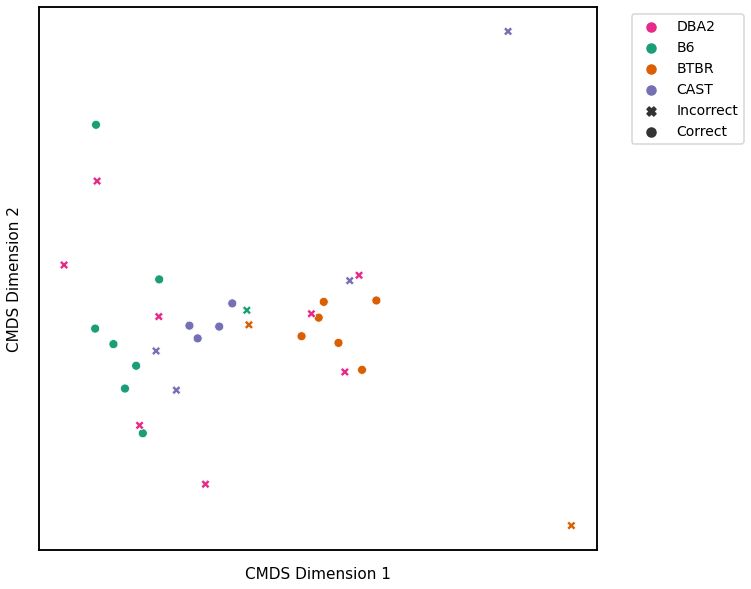

In [19]:
# cluster dissimilarity matrix
density_gm_embedding, density_gm_pred = cluster_dissim(scaled_density_dissim, y, method='gmm')
density_gm, density_gm_pred = construct_df(density_gm_embedding, y, density_gm_pred)

# calculate accuracy and ARI
density_gm_score = accuracy_score(y, density_gm_pred)
density_gm_ari = adjusted_rand_score(y, density_gm_pred)

print(f"Accuracy: {density_gm_score}")
print(f"ARI: {density_gm_ari}")

# plot clustering
plot_clustering('gmm', data=density_gm)


### Average Edge Weight

Accuracy: 0.5
ARI: 0.18691588785046728


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

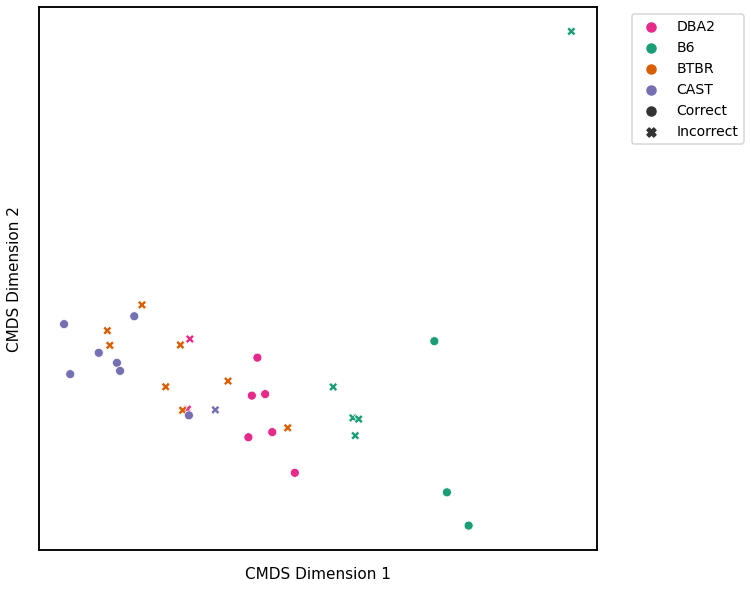

In [20]:
# cluster dissimilarity matrix
avgedgeweight_gm_embedding, avgedgeweight_gm_pred = cluster_dissim(scaled_avgedgeweight_dissim, y, method='gmm')
avgedgeweight_gm, avgedgeweight_gm_pred = construct_df(avgedgeweight_gm_embedding, y, avgedgeweight_gm_pred)

# calculate accuracy and ARI
avgedgeweight_gm_score = accuracy_score(y, avgedgeweight_gm_pred)
avgedgeweight_gm_ari = adjusted_rand_score(y, avgedgeweight_gm_pred)

print(f"Accuracy: {avgedgeweight_gm_score}")
print(f"ARI: {avgedgeweight_gm_ari}")

# plot clustering
plot_clustering('gmm', data=avgedgeweight_gm)


### Average of the Adjacency Matrix

Accuracy: 0.59375
ARI: 0.27401624980086026


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

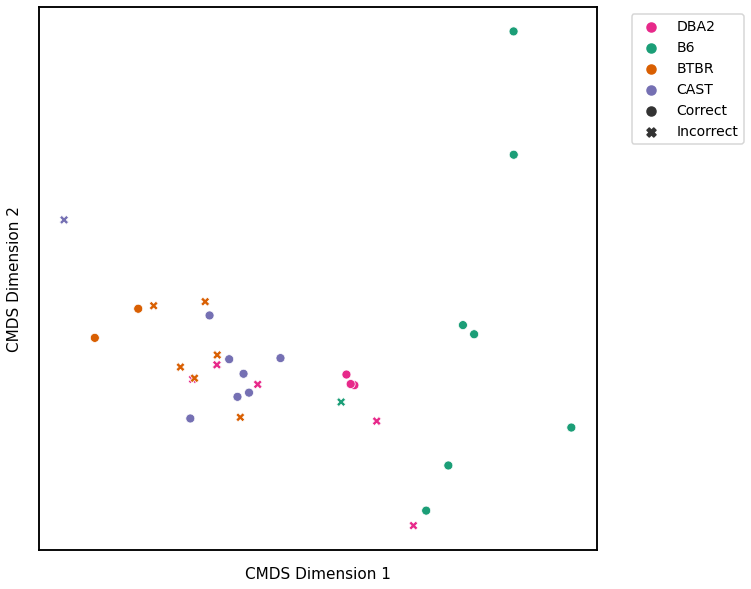

In [21]:
# cluster dissimilarity matrix
avgadjmat_gm_embedding, avgadjmat_gm_pred = cluster_dissim(scaled_avgadjmat_dissim, y, method="gmm")
avgadjmat_gm, avgadjmat_gm_pred = construct_df(avgadjmat_gm_embedding, y, avgadjmat_gm_pred)

# calculate accuracy and ARI
avgadjmat_gm_score = accuracy_score(y, avgadjmat_gm_pred)
avgadjmat_gm_ari = adjusted_rand_score(y, avgadjmat_gm_pred)

print(f"Accuracy: {avgadjmat_gm_score}")
print(f"ARI: {avgadjmat_gm_ari}")


# plot clustering
plot_clustering('gmm', data=avgadjmat_gm)


### Node Degrees - L1 Norm

Accuracy: 0.65625
ARI: 0.44858546501778757


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

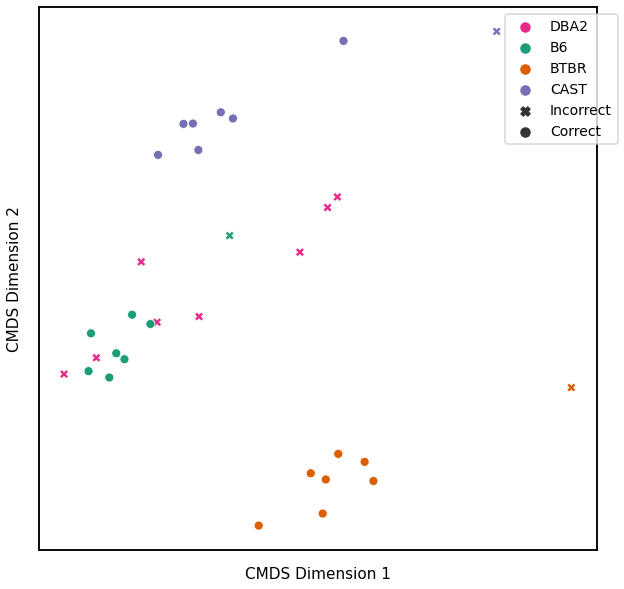

In [22]:
# cluster dissimilarity matrix
nodedeg_l1_gm_embedding, nodedeg_l1_gm_pred = cluster_dissim(scaled_nodedeg_dissim_l1, y, method="gmm")
nodedeg_l1_gm, nodedeg_l1_gm_pred = construct_df(nodedeg_l1_gm_embedding, y, nodedeg_l1_gm_pred)

# calculate accuracy and ARI
nodedeg_l1_gm_score = accuracy_score(y, nodedeg_l1_gm_pred)
nodedeg_l1_gm_ari = adjusted_rand_score(y, nodedeg_l1_gm_pred)

print(f"Accuracy: {nodedeg_l1_gm_score}")
print(f"ARI: {nodedeg_l1_gm_ari}")

# plot clustering
plot_clustering('gmm', data=nodedeg_l1_gm)

### Node Degrees - L2 Norm

Accuracy: 0.6875
ARI: 0.5248441974060973


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

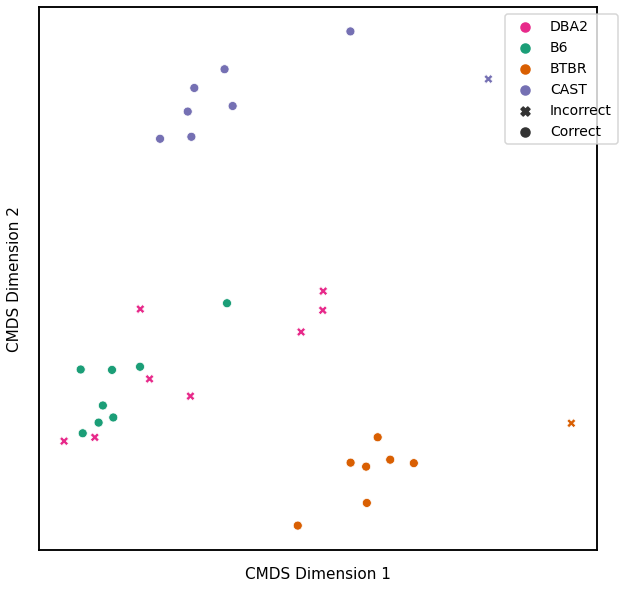

In [23]:
# cluster dissimilarity matrix
nodedeg_l2_gm_embedding, nodedeg_l2_gm_pred = cluster_dissim(scaled_nodedeg_dissim_l2, y, method="gmm")
nodedeg_l2_gm, nodedeg_l2_gm_pred = construct_df(nodedeg_l2_gm_embedding, y, nodedeg_l2_gm_pred)

# calculate accuracy and ARI
nodedeg_l2_gm_score = accuracy_score(y, nodedeg_l2_gm_pred)
nodedeg_l2_gm_ari = adjusted_rand_score(y, nodedeg_l2_gm_pred)

print(f"Accuracy: {nodedeg_l2_gm_score}")
print(f"ARI: {nodedeg_l2_gm_ari}")

# plot clustering
plot_clustering('gmm', data=nodedeg_l2_gm)

### Node Strength - L1 Norm

Accuracy: 0.84375
ARI: 0.6579851691083378


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

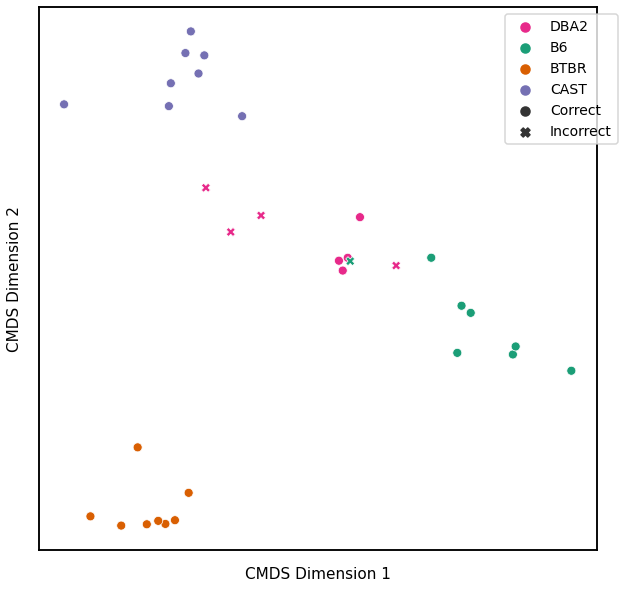

In [24]:
# cluster dissimilarity matrix
nodestr_l1_gm_embedding, nodestr_l1_gm_pred = cluster_dissim(scaled_nodestr_dissim_l1, y, method="gmm")
nodestr_l1_gm, nodestr_l1_gm_pred = construct_df(nodestr_l1_gm_embedding, y, nodestr_l1_gm_pred)

# calculate accuracy and ARI
nodestr_l1_gm_score = accuracy_score(y, nodestr_l1_gm_pred)
nodestr_l1_gm_ari = adjusted_rand_score(y, nodestr_l1_gm_pred)

print(f"Accuracy: {nodestr_l1_gm_score}")
print(f"ARI: {nodestr_l1_gm_ari}")

# plot clustering
plot_clustering('gmm', data=nodestr_l1_gm)

### Node Strength - L2 Norm

Accuracy: 0.71875
ARI: 0.6531126871552404


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

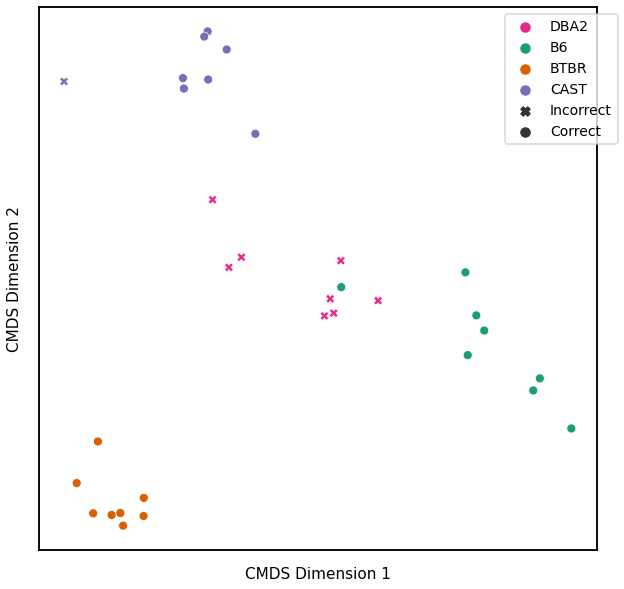

In [25]:
# cluster dissimilarity matrix
nodestr_l2_gm_embedding, nodestr_l2_gm_pred = cluster_dissim(scaled_nodestr_dissim_l2, y, method="gmm")
nodestr_l2_gm, nodestr_l2_gm_pred = construct_df(nodestr_l2_gm_embedding, y, nodestr_l2_gm_pred)

# calculate accuracy and ARI
nodestr_l2_gm_score = accuracy_score(y, nodestr_l2_gm_pred)
nodestr_l2_gm_ari = adjusted_rand_score(y, nodestr_l2_gm_pred)

print(f"Accuracy: {nodestr_l2_gm_score}")
print(f"ARI: {nodestr_l2_gm_ari}")

# plot clustering
plot_clustering('gmm', data=nodestr_l2_gm)

### Edge Weights - L1 Norm

Accuracy: 0.75
ARI: 0.5847123719464145


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

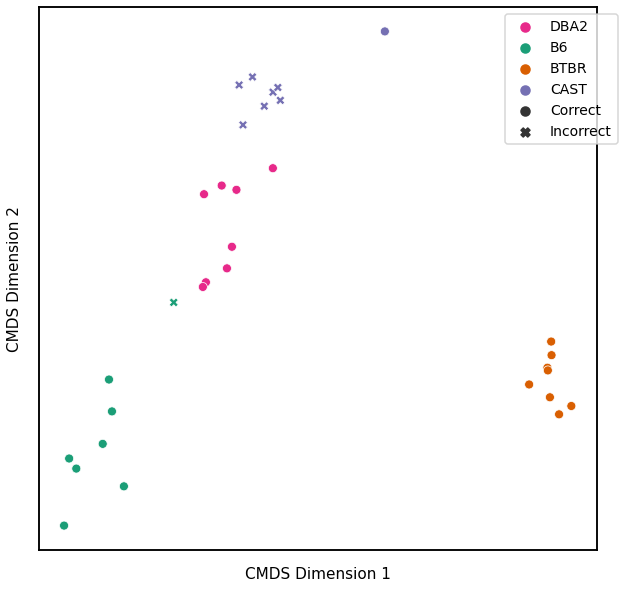

In [26]:
# cluster dissimilarity matrix
edgeweight_l1_gm_embedding, edgeweight_l1_gm_pred = cluster_dissim(scaled_edgeweight_dissim_l1, y, method="gmm")
edgeweight_l1_gm, edgeweight_l1_gm_pred = construct_df(edgeweight_l1_gm_embedding, y, edgeweight_l1_gm_pred)

# calculate accuracy and ARI
edgeweight_l1_gm_score = accuracy_score(y, edgeweight_l1_gm_pred)
edgeweight_l1_gm_ari = adjusted_rand_score(y, edgeweight_l1_gm_pred)

print(f"Accuracy: {edgeweight_l1_gm_score}")
print(f"ARI: {edgeweight_l1_gm_ari}")

# plot clustering
plot_clustering('gmm', data=edgeweight_l1_gm)

### Edge Weights - L2 Norm

Accuracy: 0.75
ARI: 0.5847123719464145


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

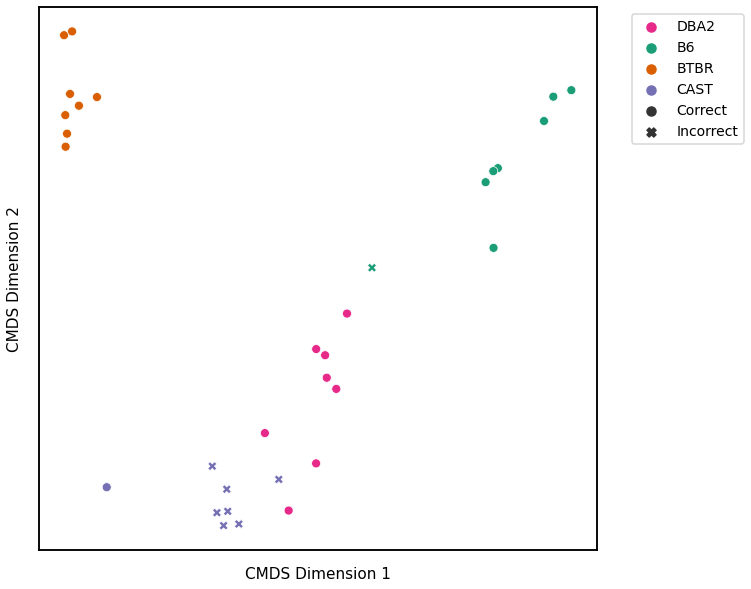

In [27]:
from graspologic.utils import symmetrize

# make dissimilarity matrix symmetric
scaled_edgeweight_dissim_l2 = symmetrize(scaled_edgeweight_dissim_l2)

# cluster dissimilarity matrix
edgeweight_l2_gm_embedding, edgeweight_l2_gm_pred = cluster_dissim(dissim_matrix=scaled_edgeweight_dissim_l2, labels=y, method="gmm")
edgeweight_l2_gm, edgeweight_l2_gm_pred = construct_df(edgeweight_l2_gm_embedding, y, edgeweight_l2_gm_pred)

# calculate accuracy and ARI
edgeweight_l2_gm_score = accuracy_score(y, edgeweight_l2_gm_pred)
edgeweight_l2_gm_ari = adjusted_rand_score(y, edgeweight_l2_gm_pred)

print(f"Accuracy: {edgeweight_l2_gm_score}")
print(f"ARI: {edgeweight_l2_gm_ari}")

# plot clustering
plot_clustering('gmm', data=edgeweight_l2_gm)


### Omnibus Embedding

Accuracy: 0.96875
ARI: 0.9137771184869276


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

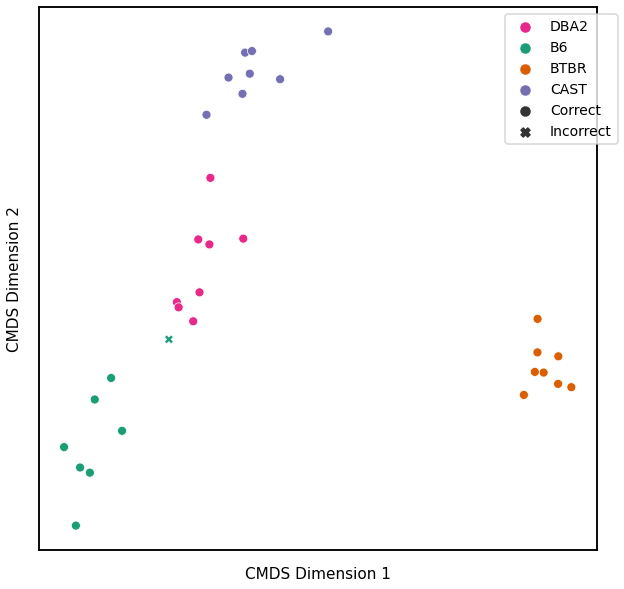

In [28]:
# cluster dissimilarity matrix
omni_gm_embedding, omni_gm_pred = cluster_dissim(scaled_omni_dissim, y, method="gmm")
omni_gm, omni_gm_pred = construct_df(omni_gm_embedding, y, omni_gm_pred)

# calculate accuracy and ARI
omni_gm_score = accuracy_score(y, omni_gm_pred)
omni_gm_ari = adjusted_rand_score(y, omni_gm_pred)

print(f"Accuracy: {omni_gm_score}")
print(f"ARI: {omni_gm_ari}")

# plot clustering
plot_clustering('gmm', data=omni_gm)

## K-Means

Similar to GMM, we first used classical multidimensional scaling to embed the dissimilarity matrices into a 2-dimensional space, then used the K-Means clustering algorithm to predict the genotypes of each point. The clusters are shown in the scatterplot below, and the colors represent the predicted genotypes and the shapes (O or X) indicate whether or not those predictions were correct.

For each kernel, the raw accuracy score, the number of correct predictions divided by the total number of samples, and the adjusted rand index, a similarity measure between two clusterings after being adjusted for chance, were reported. 

### Density

Accuracy: 0.5625
ARI: 0.24777853725222146


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

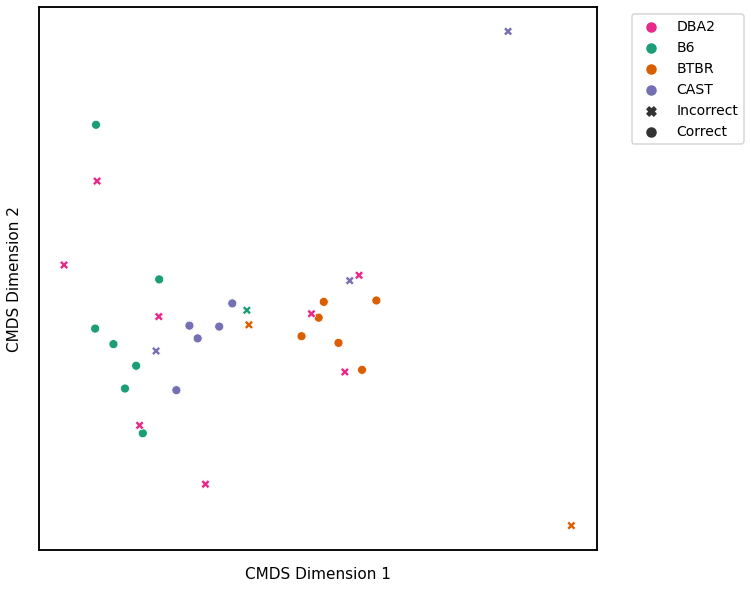

In [29]:
# cluster dissimilarity matrix
density_km_embedding, density_km_pred = cluster_dissim(scaled_density_dissim, y, method="kmeans")
density_km, density_km_pred = construct_df(density_km_embedding, y, density_km_pred)

# calculate accuracy and ARI
density_km_score = accuracy_score(y, density_km_pred)
density_km_ari = adjusted_rand_score(y, density_km_pred)

print(f"Accuracy: {density_km_score}")
print(f"ARI: {density_km_ari}")

# plot clustering
plot_clustering('kmeans', data=density_km)

### Average Edge Weight

Accuracy: 0.53125
ARI: 0.2412006432017152


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

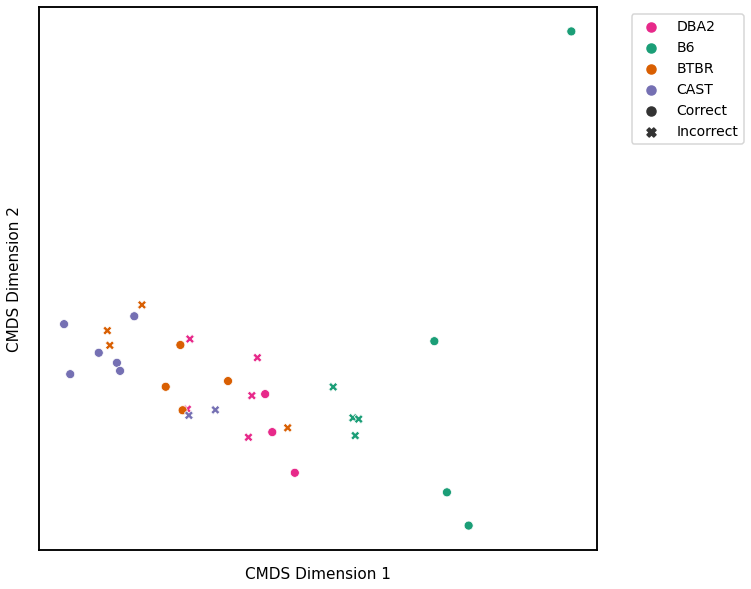

In [30]:
# cluster dissimilarity matrix
avgedgeweight_km_embedding, avgedgeweight_km_pred = cluster_dissim(scaled_avgedgeweight_dissim, y, method='kmeans')
avgedgeweight_km, avgedgeweight_km_pred = construct_df(avgedgeweight_km_embedding, y, avgedgeweight_km_pred)

# calculate accuracy and ARI
avgedgeweight_km_score = accuracy_score(y, avgedgeweight_km_pred)
avgedgeweight_km_ari = adjusted_rand_score(y, avgedgeweight_km_pred)

print(f"Accuracy: {avgedgeweight_km_score}")
print(f"ARI: {avgedgeweight_km_ari}")

# plot clustering
plot_clustering('kmeans', data=avgedgeweight_km)

### Average of the Adjacency Matrix

Accuracy: 0.65625
ARI: 0.3094958968347011


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

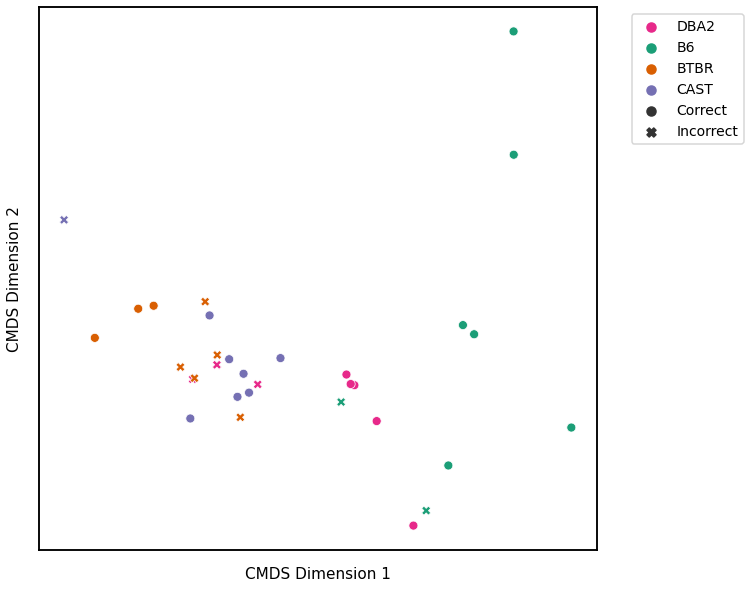

In [31]:
# cluster dissimilarity matrix
avgadjmat_km_embedding, avgadjmat_km_pred = cluster_dissim(scaled_avgadjmat_dissim, y, method='kmeans')
avgadjmat_km, avgadjmat_km_pred = construct_df(avgadjmat_km_embedding, y, avgadjmat_km_pred)

# calculate accuracy and ARI
avgadjmat_km_score = accuracy_score(y, avgadjmat_km_pred)
avgadjmat_km_ari = adjusted_rand_score(y, avgadjmat_km_pred)

print(f"Accuracy: {avgadjmat_km_score}")
print(f"ARI: {avgadjmat_km_ari}")

# plot clustering
plot_clustering('kmeans', data=avgadjmat_km)

### Node Degree - L1 Norm

Accuracy: 0.625
ARI: 0.36778063410454154


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

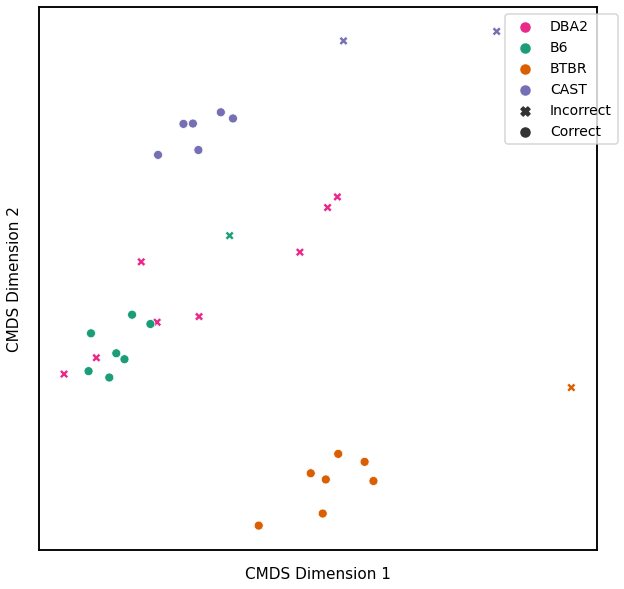

In [32]:
# cluster dissimilarity matrix
nodedeg_l1_km_embedding, nodedeg_l1_km_pred = cluster_dissim(scaled_nodedeg_dissim_l1, y, method='kmeans')
nodedeg_l1_km, nodedeg_l1_km_pred = construct_df(nodedeg_l1_km_embedding, y, nodedeg_l1_km_pred)

# calculate accuracy and ARI
nodedeg_l1_km_score = accuracy_score(y, nodedeg_l1_km_pred)
nodedeg_l1_km_ari = adjusted_rand_score(y, nodedeg_l1_km_pred)

print(f"Accuracy: {nodedeg_l1_km_score}")
print(f"ARI: {nodedeg_l1_km_ari}")

# plot clustering
plot_clustering('kmeans', data=nodedeg_l1_km)

### Node Degree - L2 Norm

Accuracy: 0.65625
ARI: 0.47026657552973344


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

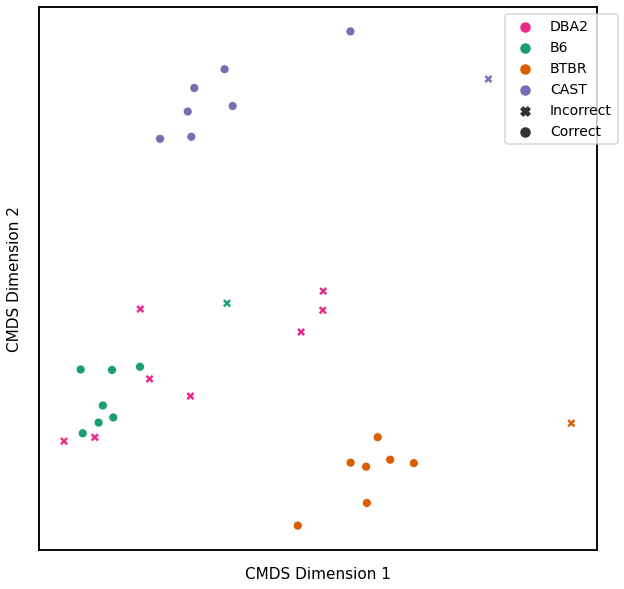

In [33]:
# cluster dissimilarity matrix
nodedeg_l2_km_embedding, nodedeg_l2_km_pred = cluster_dissim(scaled_nodedeg_dissim_l2, y, method='kmeans')
nodedeg_l2_km, nodedeg_l2_km_pred = construct_df(nodedeg_l2_km_embedding, y, nodedeg_l2_km_pred)

# calculate accuracy and ARI
nodedeg_l2_km_score = accuracy_score(y, nodedeg_l2_km_pred)
nodedeg_l2_km_ari = adjusted_rand_score(y, nodedeg_l2_km_pred)

print(f"Accuracy: {nodedeg_l2_km_score}")
print(f"ARI: {nodedeg_l2_km_ari}")

# plot clustering
plot_clustering('kmeans', data=nodedeg_l2_km)

### Node Strength - L1 Norm

Accuracy: 0.84375
ARI: 0.6558689717925387


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

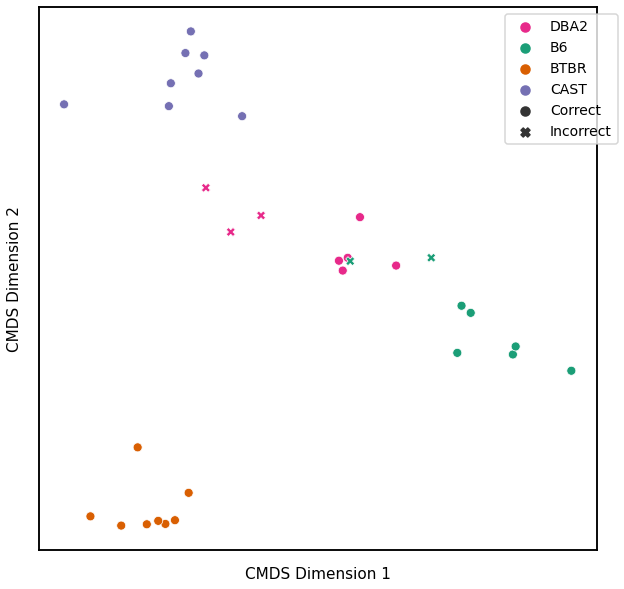

In [34]:
# cluster dissimilarity matrix
nodestr_l1_km_embedding, nodestr_l1_km_pred = cluster_dissim(scaled_nodestr_dissim_l1, y, method='kmeans')
nodestr_l1_km, nodestr_l1_km_pred = construct_df(nodestr_l1_km_embedding, y, nodestr_l1_km_pred)

# calculate accuracy and ARI
nodestr_l1_km_score = accuracy_score(y, nodestr_l1_km_pred)
nodestr_l1_km_ari = adjusted_rand_score(y, nodestr_l1_km_pred)

print(f"Accuracy: {nodestr_l1_km_score}")
print(f"ARI: {nodestr_l1_km_ari}")

# plot clustering
plot_clustering('kmeans', data=nodestr_l1_km)

### Node Strength - L2 Norm

Accuracy: 0.875
ARI: 0.7122838944494996


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

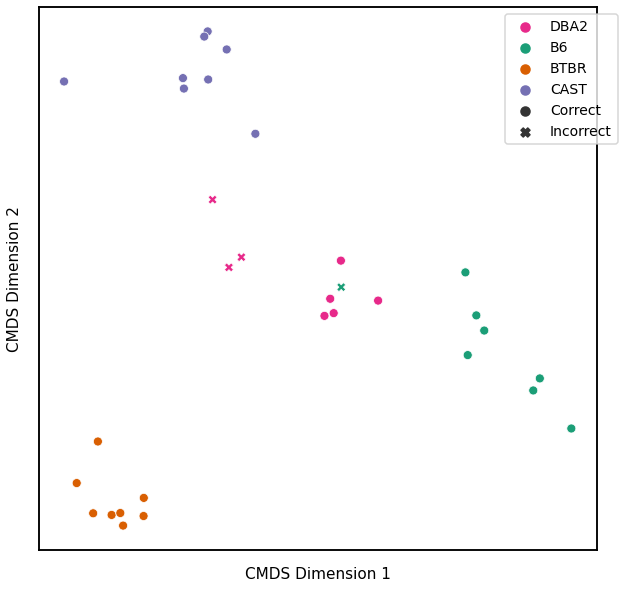

In [35]:
# cluster dissimilarity matrix
nodestr_l2_km_embedding, nodestr_l2_km_pred = cluster_dissim(scaled_nodestr_dissim_l2, y, method='kmeans')
nodestr_l2_km, nodestr_l2_km_pred = construct_df(nodestr_l2_km_embedding, y, nodestr_l2_km_pred)

# calculate accuracy and ARI
nodestr_l2_km_score = accuracy_score(y, nodestr_l2_km_pred)
nodestr_l2_km_ari = adjusted_rand_score(y, nodestr_l2_km_pred)

print(f"Accuracy: {nodestr_l2_km_score}")
print(f"ARI: {nodestr_l2_km_ari}")

# plot clustering
plot_clustering('kmeans', data=nodestr_l2_km)

### Edge Weight - L1 Norm

Accuracy: 0.9375
ARI: 0.8333024290747265


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

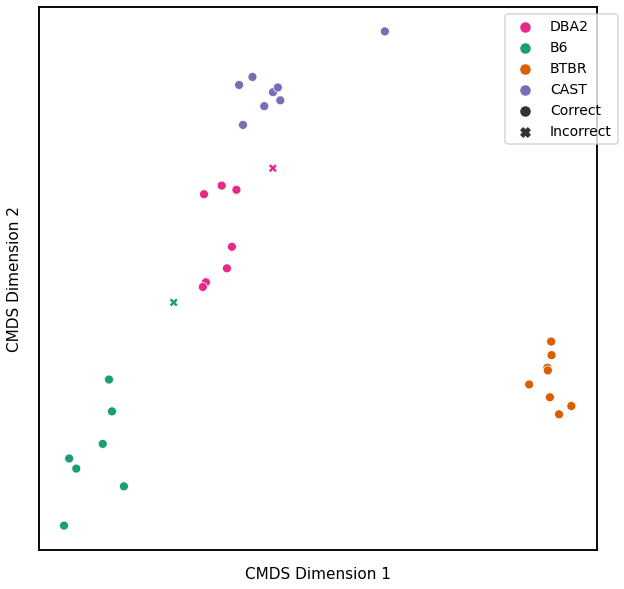

In [36]:
# cluster dissimilarity matrix
edgeweight_l1_km_embedding, edgeweight_l1_km_pred = cluster_dissim(scaled_edgeweight_dissim_l1, y, method='kmeans')
edgeweight_l1_km, edgeweight_l1_km_pred = construct_df(edgeweight_l1_km_embedding, y, edgeweight_l1_km_pred)

# calculate accuracy and ARI
edgeweight_l1_km_score = accuracy_score(y, edgeweight_l1_km_pred)
edgeweight_l1_km_ari = adjusted_rand_score(y, edgeweight_l1_km_pred)

print(f"Accuracy: {edgeweight_l1_km_score}")
print(f"ARI: {edgeweight_l1_km_ari}")

# plot clustering
plot_clustering('kmeans', data=edgeweight_l1_km)

### Edge Weight - L2 Norm

Accuracy: 0.90625
ARI: 0.7658006264971439


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

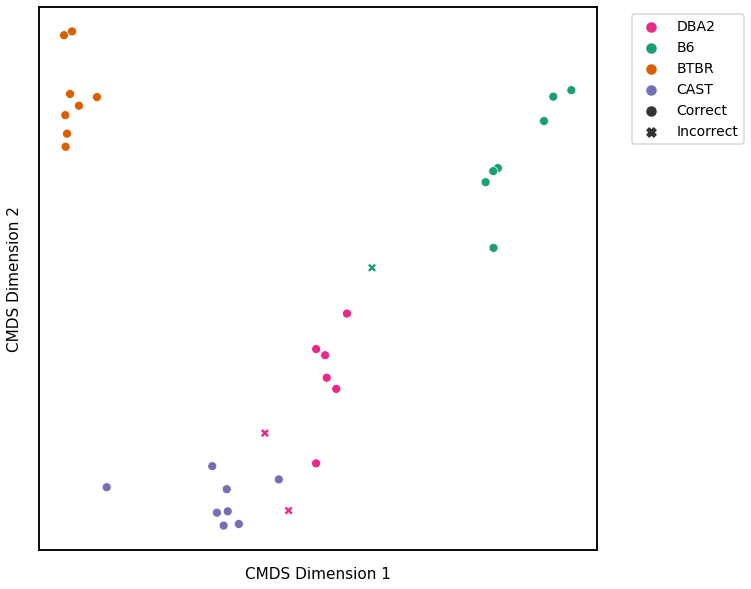

In [37]:
# cluster dissimilarity matrix
edgeweight_l2_km_embedding, edgeweight_l2_km_pred = cluster_dissim(scaled_edgeweight_dissim_l2, y, method='kmeans')
edgeweight_l2_km, edgeweight_l2_km_pred = construct_df(edgeweight_l2_km_embedding, y, edgeweight_l2_km_pred)

# calculate accuracy and ARI
edgeweight_l2_km_score = accuracy_score(y, edgeweight_l2_km_pred)
edgeweight_l2_km_ari = adjusted_rand_score(y, edgeweight_l2_km_pred)

print(f"Accuracy: {edgeweight_l2_km_score}")
print(f"ARI: {edgeweight_l2_km_ari}")

# plot clustering
plot_clustering('kmeans', data=edgeweight_l2_km)

### Omnibus Embedding

Accuracy: 0.96875
ARI: 0.9137771184869276


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

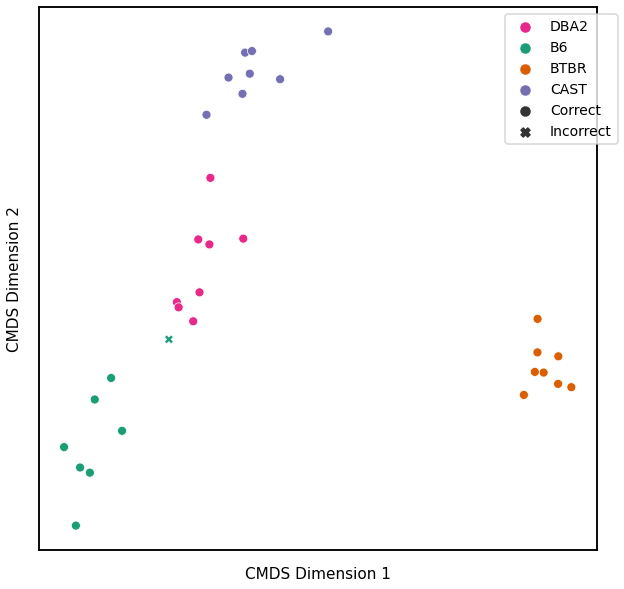

In [38]:
# cluster dissimilarity matrix
omni_km_embedding, omni_km_pred = cluster_dissim(scaled_omni_dissim, y, method='kmeans')
omni_km, omni_km_pred = construct_df(omni_km_embedding, y, omni_km_pred)

# calculate accuracy and ARI
omni_km_score = accuracy_score(y, omni_km_pred)
omni_km_ari = adjusted_rand_score(y, omni_km_pred)

print(f"Accuracy: {omni_km_score}")
print(f"ARI: {omni_km_ari}")

# plot clustering
plot_clustering('kmeans', data=omni_km)

## ARI Plot

We will use the adjusted rand index (ARI) to compare the performace of each clustering algorithm on each kernel. The ARI values are visualized with a scatter plot below, and the colors represent the different clustering algorithms.

In [39]:
# construct symmetric random matrix with zero diagonal
np.random.seed(42)
scaled_random = np.random.rand(len(graphs), len(graphs))
scaled_random = symmetrize(scaled_random)

# agglomerative clustering
random_linkage_matrix, random_pred = cluster_dissim(scaled_random, y, method="agg")
random_pred = remap_labels(y, random_pred)
random_agg_score = accuracy_score(y, random_pred)
random_agg_ari = adjusted_rand_score(y, random_pred)

# GMM
random_gm_embedding, random_gm_pred = cluster_dissim(scaled_random, y, method="gmm")
random_gm, random_gm_pred = construct_df(random_gm_embedding, y, random_gm_pred)
random_gm_score = accuracy_score(y, random_gm_pred)
random_gm_ari = adjusted_rand_score(y, random_gm_pred)

# K-Means
random_km_embedding, random_km_pred = cluster_dissim(scaled_random, y, method="kmeans")
random_km, random_km_pred = construct_df(random_km_embedding, y, random_km_pred)
random_km_score = accuracy_score(y, random_km_pred)
random_km_ari = adjusted_rand_score(y, random_km_pred)

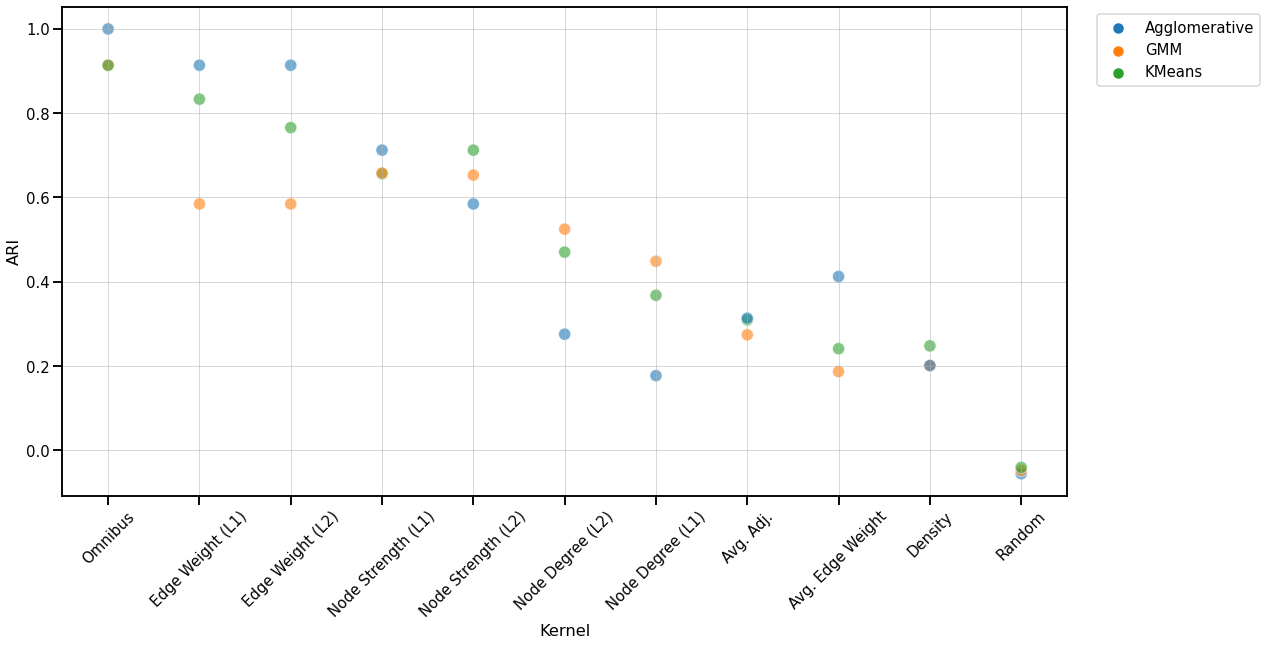

In [58]:
kernels = ['Omnibus', 'Density', 'Avg. Edge Weight', 'Avg. Adj.', 'Node Degree (L1)', 'Node Degree (L2)', 'Node Strength (L1)', \
    'Node Strength (L2)', 'Edge Weight (L1)', 'Edge Weight (L2)', 'Random']
kernels_df = [kernel for kernel in kernels for i in range(3)]
agg_ari = [omni_agg_ari, density_agg_ari, avgedgeweight_agg_ari, avgadjmat_agg_ari, nodedeg_l1_agg_ari, nodedeg_l2_agg_ari, \
    nodestr_l1_agg_ari, nodestr_l2_agg_ari, edgeweight_l1_agg_ari, edgeweight_l2_agg_ari, random_agg_ari]
gm_ari = [omni_gm_ari, density_gm_ari, avgedgeweight_gm_ari, avgadjmat_gm_ari, nodedeg_l1_gm_ari, nodedeg_l2_gm_ari, \
    nodestr_l1_gm_ari, nodestr_l2_gm_ari, edgeweight_l1_gm_ari, edgeweight_l2_gm_ari, random_gm_ari]
km_ari = [omni_km_ari, density_km_ari, avgedgeweight_km_ari, avgadjmat_km_ari, nodedeg_l1_km_ari, nodedeg_l2_km_ari, \
    nodestr_l1_km_ari, nodestr_l2_km_ari, edgeweight_l1_km_ari, edgeweight_l2_km_ari, random_km_ari]

ari_vals = np.vstack((np.array(agg_ari), np.array(gm_ari), np.array(km_ari)))
ari_vals = np.ravel(ari_vals.T)
algos = ['Agglomerative', 'GMM', 'KMeans'] * len(agg_ari)

ari_df = pd.DataFrame(list(zip(kernels_df, ari_vals, algos)), columns=["Kernel", "ARI", "Algorithm"])

avg_ari_vals = (np.array(agg_ari) + np.array(gm_ari) + np.array(km_ari)) / 3
avg_ari_vals = [val for val in avg_ari_vals for i in range(3)]
ari_df["Average"] = avg_ari_vals
ari_df = ari_df.sort_values(by=['Average'], ascending=False)

fig, ax = plt.subplots(1,1, figsize=(18, 9), facecolor='w')
sns.set_context("talk", font_scale=0.9)
sns.scatterplot(x="Kernel", y="ARI", hue="Algorithm", data=ari_df, alpha=0.6, s=150)
plt.legend(bbox_to_anchor = (1.2, 1))
plt.xticks(rotation=45)
plt.grid(linewidth=0.5)